In [ ]:
# This tests algorithms to remove cosmic rays from multiepoch spectra (in particular from SDSS stripe 82
# spectra, which are too many for manual removal)

# Created 2021 May 10 by E.S.

In [1]:
import pandas as pd
import numpy as np
import glob
import sys
import os
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

%matplotlib inline

In [2]:
# find names of spectra for which continuum has been calculated

stem_s82_norm = "/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/" + \
                "realizations_output/norm/final/"
# find individual file names
file_list = glob.glob(stem_s82_norm + "*")
# find all parent names (i.e., one name for each target, whether or not multiepoch observations were made)
parent_list = list(set([i.split("g00")[0] for i in file_list]))

In [9]:
def flag_from_avg(df_empir_pass,df_avg_pass,df_median_pass,sigma_choice=1):
    '''
    Average two spectra and flag points based on their deviation from the average spectrum
    
    INPUTS:
    df_empir_pass: dataframe of empirical spectrum
    df_avg_pass: dataframe of average spectrum
    df_median_pass: dataframe of median spectrum
    sigma_choice: threshold for clipping
    '''
    
    # initialize DataFrame to return
    masked_spec = df_empir_pass.copy(deep=True)
    #masked_spec["flux_masked_1"] = masked_spec["flux"]
    
    # take difference between empirical spectrum and the AVERAGE of the AVERAGE AND MEDIAN spectrum
    # (note this preserves sign information, and (if only 2 spectra are being compared) protects against 
    # misidentification of a cosmic ray in 1 spectrum when the ray is actually in the other)
    #initialize DataFrame for taking an average of some kind
    standin_df = df_avg_pass.copy(deep=True)
    standin_df["median_flux"] = df_median_pass["median_flux"]
    # remove column of wavelengths
    print(standin_df.keys())
    standin_df = standin_df.drop(labels=["wavel"],axis=1)
    # find the mean of a mean and a median
    standin_df["mean_of_stuff"] = standin_df.mean(axis=1) # average of the columns
    
    #avg_flux = np.expand_dims(df_avg_pass["avg_flux"].values,axis=1)
    #median_flux = np.expand_dims(df_median_pass["median_flux"].values,axis=1)
    #print(np.expand_dims(avg_flux,axis=0).shape)
    #print(median_flux.shape)
    #mean_median_combo = np.mean(avg_flux,median_flux)
    masked_spec["diff"] = np.subtract(df_empir_pass["flux"],standin_df["mean_of_stuff"])
    
    # mask deviant points
    # logic: is difference in the array beyond error bounds?
    error_bound = sigma_choice*np.nanstd(masked_spec["diff"])
    logic_1 = np.greater(masked_spec["diff"],error_bound)
    masked_spec["flux_flag_1"] = logic_1 # flag these points as suspect
    
    return masked_spec, error_bound

In [10]:
# Steps for removing cosmic rays from spectra with >1 for a given object

# Step 1:
# Average two normalized spectra (following the normalization of the raw spectra)
# Flag (#1) points that are N sigma off from the average [use cenfunc=“median”]; keep track of direction

# Step 2:
# Go back to the spectra BEFORE ANY NORMALIZATION and averaging, and remove (mask) the flagged points
# Normalize them anew
# Sigma-clip again, but use larger sigmas than in Step 1, and flag those points with another flag (#2)
# Remove (mask) those points from the spectra

# Step 3:
# Normalize one last time


# find the file names of spectra corresponding to each parent; if there is only 1, ignore; 
# if >= 2, do median comparison to flag it for cosmic rays

for t in range(0,100):#len(parent_list)):
    
    matching = list(filter(lambda x: parent_list[t] in x, file_list))
    
    print("-------------------------")
    
    if (len(matching) == 1):
        
        print("Only one match found:")
        print(matching)
    
    elif (len(matching) >= 2):
        
        print(str(len(matching)) + " matches found:")
        print(matching)
        
        # dictionary to hold dataframes
        d = {}
        
        # intialize array to contain all fluxes
        df_dummy = pd.read_csv(matching[0], names=["wavel","flux","noise"], delim_whitespace=True)
        aggregate_flux_array = np.nan*np.ones((len(df_dummy),len(matching)))
        
        # collect spectra in single dictionary
        for p in range(0,len(matching)):
            
            df_single_p = pd.read_csv(matching[p], names=["wavel","flux","noise"], delim_whitespace=True)
            
            #plt.plot(df_single_p["wavel"],df_single_p["flux"])
            
            # sanity check that wavelength abcissa are the same
            if p==0:
                # for checking wavel abcissa is same
                wavel_initial = df_single_p["wavel"].values
            else:
                if len(np.setdiff1d(df_single_p["wavel"].values,wavel_initial) >= 1):
                    print("Hey, the wavelength abcissas are not the same!")
                    sys.exit()

            # put fluxes into array
            aggregate_flux_array[:,p] = df_single_p["flux"].values
            
        # take mean flux of all the spectra
        mean_flux_array = np.mean(aggregate_flux_array,axis=1)
        
        # cast mean spectrum data as DataFrame
        df_mean = pd.DataFrame(mean_flux_array,columns=["avg_flux"])
        df_mean["wavel"] = df_single_p["wavel"] # uses last spectrum read in
        # include median flux too (important for identifying cosmic rays when only 2 spectra are compared)
        median_flux_array = np.median(aggregate_flux_array,axis=1)
        print(median_flux_array)
        df_median = pd.DataFrame(median_flux_array,columns=["median_flux"])
        df_median["wavel"] = df_single_p["wavel"] # uses last spectrum read in
        #mean_flux_array["median_flux"] = pd.Series(median_flux_array.tolist())
        
        for p in range(0,len(matching)):
            # test each empirical spectrum against the mean, and flag points
            df_single_p = pd.read_csv(matching[p], names=["wavel","flux","noise"], delim_whitespace=True)
            flagged_empirical, limit = flag_from_avg(
                                                    df_empir_pass = df_single_p,
                                                    df_avg_pass = df_mean,
                                                    df_median_pass = df_median,
                                                    sigma_choice=5
                                                    )
            
            # if cosmic ray appears to be in an absorption line, discard the spectrum
            ## ## TBD


            '''
            plt.plot(wavel_initial,mean_flux_array,linestyle="--",color="k")
            plt.show()
            plt.clf()
            '''

            plt.figure(figsize=(24,10))
            plt.plot(flagged_empirical["wavel"],np.subtract(flagged_empirical["flux_flag_1"],1),color="gray",alpha=1)
            #.axvline(x=0, ymin=0, ymax=1
            plt.plot(flagged_empirical["wavel"],flagged_empirical["diff"],label="diff")
            plt.plot(df_mean["wavel"],np.add(df_mean["avg_flux"],0.2),label="mean")
            plt.plot(flagged_empirical["wavel"],flagged_empirical["flux"],label="empirical")
            #plt.plot(df_single_p["wavel"].where(test["flux_flag_1"] == True),
            #             df_single_p["flux"].where(test["flux_flag_1"] == True),
            #         label="flagged",color="k",linewidth=4)
            plt.plot([3900,5000],[limit,limit],linestyle="--")
            plt.title(str(os.path.basename(matching[p])))
            plt.legend(loc="lower right")
            plt.savefig("plot_" + str(os.path.basename(matching[p])) + ".png")
            plt.clf()

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0485-51909-0107g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0485-51909-0107g001.dat_000']
[1.      1.02525 0.7894  1.1532  0.72615 0.96635 0.9629  1.0135  0.78165
 1.0608  0.89185 0.8884  0.88395 0.8428  0.9389  0.84665 0.82695 0.8873
 0.8595  1.01435 0.9586  0.81465 0.85165 0.7465  0.5985  0.3754  0.3913
 0.7141  0.9485  0.9286  0.8648  0.94695 0.91245 0.8084  0.88145 0.9497
 0.90135 0.837   0.9605  0.7915  0.8447  0.8056  0.86515 0.76545 0.80815
 0.7115  0.6304  0.78745 0.65015 0.5606  0.3132  0.22545 0.3582  0.49015
 0.60735 0.6364  0.73705 0.5077  0.7606  0.80295 0.7691  0.7417  0.84945
 0.8501  0.8887  0.91905 0.8747  0.9543  0.88475 0.9752  0.86555 0.8889
 0.8301  0.9305  0.9212  0.86845 0.9381  0.88305 0.88525 0.97705 0.96665
 0.9457  0.91405 0.

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2085-53379-0489g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0505-52317-0207g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1360-53033-0575g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1360-53033-0575g002.dat_000']
[1.      0.99545 1.04005 0.94895 0.94685 1.036   1.00635 1.04235 1.0141
 0.90485 0.9544  0.9759  1.01325 0.8908  0.94505 0.9322  0.96935 0.95405
 1.00125 0.8966  0.872   0.77305 0.6376  0.358   0.39315 0.65985 0.8618
 0.91625 0.96

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1800-53884-0523g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0852-52375-0151g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0518-52282-0635g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2670-54115-0397g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2670-54115-0397g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/nor

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2824-54452-0151g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2824-54452-0151g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2824-54452-0151g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2824-54452-0151g001.dat_000']
[1.      1.0205  0.97465 0.95835 1.0181  1.01795 1.0292  1.0044  0.9139
 1.0199  0.9276  0.94805 0.9347  0.94265 0.9679  0.9657  0.9826  0.9446
 0.91815 0.8014  0.6882  0.42775 0.24685 0.2973  0.55755 0.79105 0.8977
 0.9713  0.96095 0.92275 0.9472  0.9959  0.9509  0.9

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')


/Users/bandari/anaconda3/envs/rrl_env/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0976-52413-0496g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0976-52413-0496g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0976-52413-0496g002.

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1409-52824-0164g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0944-52614-0101g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3480-54999-0536g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1237-52762-0349g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1237-52762-0349g002.dat_000', '/Users/bandari/Documents/git.repos/rrl

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0346-51693-0587g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0346-51693-0587g001.dat_000']
[1.      0.99765 0.9724  0.97065 0.99325 1.0136  0.99065 1.04005 1.02635
 0.962   0.99785 1.01055 1.01545 1.03895 0.9736  0.99285 0.9659  0.96565
 1.03025 1.02145 0.97585 0.973   0.9285  0.8119  0.62215 0.68085 0.8767
 0.96275 1.02995 1.02235 0.9804  0.97795 1.01135 0.95505 0.96435 0.9446
 0.914   0.9133  0.95355 0.9167  0.8922  0.8836  0.855   0.82735 0.80305
 0.72375 0.6696  0.63225 0.5169  0.38465 0.2715  0.34715 0.4523  0.56085
 0.6487  0.681   0.73205 0.7626  0.8298  0.82825 0.848   0.86695 0.90555
 0.88585 0.9423  0.96285 0.922   0.96065 0.9395  0.95715 0.93515 0.9168
 1.00495 0.99105 1.00165 0.9677

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
7 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3128-54776-0264g007.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3128-54776-0264g006.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3128-54776-0264g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3128-54776-0264g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3128-54776-0264g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3128-54776-0264g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2145-54212-0489g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2145-54212-0489g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2145-54212-0489g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2145-54212-0489g004.dat_000']
[1.      0.9114  1.0113  1.00975 0.9848  0.99455 0.97745 1.0183  1.0333
 1.02675 0.9855  0.97045 0.962   0.99665 0.97045 0.96275 1.0103  0.98355
 0.98865 0.9729  0.9881  0.94275 0.91895 0.8371  0.5551  0.368   0.4463
 0.76265 0.90255 0.96205 0.97925 0.99645 0.96965 0.

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0336-51999-0228g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2482-54175-0062g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0349-51699-0541g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0349-51699-0541g001.dat_000']
[1.      1.0129  0.9624  0.9856  0.9988  1.0182  1.02145 1.0264  0.99845
 0.95595 0.98785 0.9996  0.99365 0.99165 0.9947  0.99955 0.99655 1.0179
 1.01955 0.97755 0.95245 

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1298-52964-0198g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2518-54243-0127g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2552-54632-0247g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1996-53436-0071g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2459-54544-0529g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metall

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2955-54562-0478g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2955-54562-0478g002.dat_000']
[1.      0.9223  1.21585 0.834   0.9827  1.0034  0.93815 0.8209  1.00175
 0.8388  1.0189  0.9104  0.90075 0.88245 0.9163  0.92445 0.85185 1.01445
 0.85035 0.79795 0.8202  0.5985  0.46705 0.248   0.41515 0.80255 0.71895
 0.76365 0.80875 0.9432  0.8702  0.9179  0.939   0.8614  0.88325 0.90945
 0.98785 0.93515 0.92895 0.77675 0.84845 0.9074  0.9226  0.88875 0.86585
 0.81255 0.57295 0.4103  0.34215 0.35055 0.5436  0.6703  0.66255 0.7396
 0.6951  0.8615  0.9358  0.78355 0.8804  0.9067  0.9298  0.96875 0.8562
 0.886   0.862   0.9575  0.9632  0.9891  0.

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3390-54945-0575g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3390-54945-0575g002.dat_000']
[1.      1.0238  0.9832  1.00735 0.99535 0.98765 0.9413  0.96715 1.0233
 0.99525 0.99615 0.98985 1.02475 0.97885 0.9923  1.0156  1.0069  0.96255
 0.9842  0.9638  0.82085 0.68725 0.909   0.95385 0.88965 0.89565 0.96355
 0.96405 1.00985 0.95515 1.00745 0.90635 0.9309  0.9609  0.91055 0.91875
 0.9261  0.83415 0.88215 0.8465  0.79595 0.7597  0.67545 0.68625 0.57235
 0.45465

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2433-53820-0561g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2433-53820-0561g002.dat_000']
[1.      0.9993  1.0387  1.003   0.953   0.9794  1.01855 1.01105 1.05475
 1.02875 0.9379  0.96945 0.9674  1.0162  1.0104  0.9473  0.96485 0.91505
 0.9646  0.97255 0.96615 0.88945 0.8938  0.7577  0.4286  0.34975 0.6708
 0.8709  0.91405 0.93165 0.97175 0.941   0.90225 0.9566  0.9783  0.9443
 0.95055 0.94015 0.9235  0.93325 0.9112  0.8864  0.79705 0.8373  0.79115
 0.7351  0.704   0.6782  0.57645 0.4066  0.1829  0.28535 0.4634  0.54315
 0.68175 0.70215 0.77285 0.79195 0.8815  0.83065 0.8673  0.886   0.9168
 0.90555 0.93415 0.92635 0.90295 0.95575 0.93955 0.9167  0.9513  0.90855
 1.0058  0.94555 1.0066  0.94    0.907   0.9881  1.0074  0.9843  0.97585
 0.9051  0.96245 0

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1399-53172-0025g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1399-53172-0025g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1399-53172-0025g002.dat_000']
[1.     0.9783 0.9791 1.0013 1.0459 0.996  1.005  0.9407 0.9941 0.9777
 1.0066 0.9742 0.9853 0.999  0.9515 1.0123 0.9808 0.9808 0.9696 0.9699
 0.8189 0.6192 0.6584 0.8726 0.9265 0.9278 0.9833 0.991  0.965  0.9665
 0.9088 0.9095 0.9126 0.8881 0.8854 0.9013 0.8913 0.9187 0.8272 0.8292
 0.7921 0.7561 0.6919 0.6919 0.609  0.4781 0.3166 0.2346 0.3189 0.4346
 0.5461 0.6521 0.6775 0.7607 0.7721 0.8267 0.8205 0.8741 0.8676 0.8577
 0.9209 0.9038 0.9321 0.9221 0.9766 0.9496 0

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0559-52316-0421g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0559-52316-0421g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0559-52316-0421g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0559-52316-0421g001.dat_000']
[1.      0.9803  0.9317  0.9763  0.93205 1.05635 0.9323  1.0141  1.04025
 1.05815 1.05205 0.9281  0.9299  0.9674  0.89675 0.87985 0.9351  0.94535
 0.9286  0.98055 0.9486  0.8443  0.75615 0.67265 0.4959  0.2883  0.3495
 0.57395 0.8205  0.8916  0.9077  0.9522  0.8764  0.87425 0.91    0.95155
 0.9119  0.8694  0.91575 0.8633  0.92

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0341-51690-0353g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2183-53536-0305g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2289-53708-0579g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2603-54479-0168g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_met

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2311-54331-0103g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2311-54331-0103g001.dat_000']
[1.      0.9397  0.83095 0.96195 0.97205 1.01245 0.8818  0.83715 0.93715
 0.8906  0.945   0.8496  0.9126  0.9394  0.969   0.836   0.8917  0.7856
 1.0628  0.82415 0.99925 0.8476  0.8334  0.9063  0.8451  0.4605  0.33715
 0.5421  0.84695 0.86605 0.912   0.90425 0.9651  0.8535  0.80735 0.8352
 0.8688  0.91975 0.92795 0.82715 0.88645 0.8947  0.8194  0.76825 0.89635
 0.85625 0.76515 0.886   0.70935 0.59855 0.38765 0.39655 0.43855 0.56345
 0.72965 0.7644  0.8773  0.78725 0.94065 0.86065 0.8171  0.92225 0.97855
 0.8591  0.92395 0.9823  0.96395 0.959   0.8785  0.9073  0.8735  1.02675
 0.9401  1.021   0.95495 0.9259  0.85215 0.90875 0.92305 0.92855 0.9326
 0.8589  0.93165 0

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1801-54156-0251g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1801-54156-0251g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1801-54156-0251g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1801-54156-0251g002.dat_000']
[1.      1.00425 0.9836  0.9768  0.9307  1.0002  0.99265 0.9757  0.95365
 1.01425 0.99845 1.07175 1.02595 1.01125 0.9768  0.9902  0.99495 0.9864
 0.9536  0.99125 0.95125 0.96385 0.9385  0.9782  0.8592  0.82485 0.78355
 0.5946  0.3991  0.41155 0.6715  0.82975 0.93605 0

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2787-54552-0102g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2240-53823-0005g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2240-53823-0005g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2240-53823-0005g003.dat_000']
[1.     0.9439 1.0146 0.9906 1.0031 0.9532 0.9614 0.9842 1.0264 1.0355
 1.0109 0.9645 0.9606 1.008  1.0057 0.9557 0.996  0.9895 0.9741 1.0591
 0.983  0.966  0.9732 0.9214 0.7198 0.5308 0.6839 0.8582 0.9751 1.0017
 1.0108 0.9994 0.9485 0.9622 0.906  1.0047 0.9548 0.9568 0.9512 0.9436
 0.9241 0.9179 0.8752 0.868  0.8776 0.7858 0.8321 0.792

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2968-54585-0406g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3213-54865-0068g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3213-54865-0068g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3213-54865-0068g001.dat_000']
[1.     0.8232 0.9759 0.9948 0.7924 1.0628 0.8982 0.9856 0.868  0.8641
 0.8914 0.8011 0.9173 0.7497 0.8552 0.8805 0.8942 0.7379 0.8667 0.8739
 0.9932 0.8613 0.7162 0.735  0.4689 0.2415 0.2824 0.6702 0.7251 0.8519
 0.900

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2689-54149-0351g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2689-54149-0351g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2689-54149-0351g002.dat_000']
[1.     0.8796 0.945  0.9394 1.0112 0.9098 0.959  0.9442 0.9669 1.0974
 0.9383 0.949  0.9925 0.9504 1.0201 0.9165 0.8903 0.9678 0.8631 1.0292
 0.9656 0.9028 0.8727 0.8549 0.7613 0.4922 0.4143 0.8065 0.8964 0.9468
 0.9168 0.9914 0.8214 0.9671 0.9127 0.8522 0.944  0.9725 0.9379 0.8489
 0.9307 0.9596 0.8308 0.8277 0.8737 0.8973 0.8512 0.7111 0.682  0.585
 0.3773 0.2252 0.3809 0.4351 0.6193 0.7136 0.7446 0.7757 0.8333 0.789
 0.9206 0.8456 0.9159 0.9579 0.9029 0.9314 0.8

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2716-54628-0051g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0619-52056-0232g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-0619-52056-0232g001.dat_000']
[1.      0.9816  1.03125 0.9945  0.9781  0.99525 1.0232  1.01485 1.0231
 0.99785 0.9918  0.98635 0.9987  1.01325 1.0138  0.99985 0.9956  1.00235
 1.0327  1.0224  0.94305 0.94165 0.8895  0.68395 0.4453  0.5408  0.8369
 0.9346  1.00325 1.02145 1.01265 0.96835 0.9528  1.0351  0.9898  0.96375
 0.9795  0.9317  0.9411  0.90445 0.8472  0.81325 0.78555 0.71515 0.722
 0.63825 0.6346  0.56425 0.4321  0.2516  0.2269  0.31435 0.4

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1009-52644-0254g001.dat_000']
-------------------------
8 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3161-54779-0541g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3161-54779-0541g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3161-54779-0541g008.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3161-54779-0541g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3161-54779-0541g004.dat_0

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1397-53119-0456g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1397-53119-0456g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1397-53119-0456g003.dat_000']
[1.     0.9961 0.9692 0.9794 1.0192 1.0148 1.0031 1.023  0.9311 0.9682
 1.0176 1.0073 1.0364 1.0201 1.0127 0.9706 0.9806 0.9845 0.9683 0.9541
 1.0135 0.9212 0.7146 0.6357 0.8222 0.9277 1.0029 0.9899 0.9753 1.0112
 0.949  0.9645 0.9892 0.9413 0.95   0.9508 0.8985 0.8946 0.8595 0.8245
 0.7929 0.7632 0.7351 0.6763 0.6228 0.5989 0.4963 0.3979 0.2949 0.3173
 0.4081 0.4883 0.5684 0.6279 0.6898 0.7602 0.7686 0.805

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-3265-54888-0039g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1317-52765-0045g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1609-53142-0589g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1609-53142-0589g001.dat_000']
[1.      1.0366  0.97605 0.9679  1.0032  0.89745 1.0018  1.1073  0.8779
 0.79245 1.02915 0.7807  0.99915 0.88135 0.89245 0.9081  0.75165 0.9512
 0.74995 0.9327  0.77265 0.76675 0.61005 0.40195 0.25225 0.1738  0.61495
 0.689   0.83

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2209-53907-0452g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2209-53907-0452g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-2209-53907-0452g003.dat_000']
[1.     1.0169 0.9447 0.9743 1.0197 0.9099 1.012  0.92   0.9526 0.9634
 1.0175 0.9806 0.8972 0.9761 0.9566 1.     0.9908 1.0335 0.8308 0.9707
 0.9372 0.7316 0.5315 0.8006 0.7808 0.8375 0.9501 0.9781 0.9719 0.9231
 0.9888 0.9699 0.9709 0.9273 0.9241 0.8964 0.9366 0.8763 0.8008 0.8342
 0.7863 0.8531 0.7149 0.7576 0.6907 0.5814 0.4475 0.3039 0.2521 0.4151
 0.4978 0.6279 0.6811 0.7687 0.7287 0.7805 0.845  0.8439 0.8482 0.9203
 0.9201 0.8892 0.9287 0.948  0.8916 0.9086 0

Index(['avg_flux', 'wavel', 'median_flux'], dtype='object')
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/final/spec-1285-52723-0027g001.dat_000']


<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

<Figure size 1728x720 with 0 Axes>

In [54]:
test, limit = flag_from_avg(df_empir_pass = df_single_p,
              df_avg_pass = df_mean,
              sigma_choice=5)

In [55]:
limit

0.25074013657105826

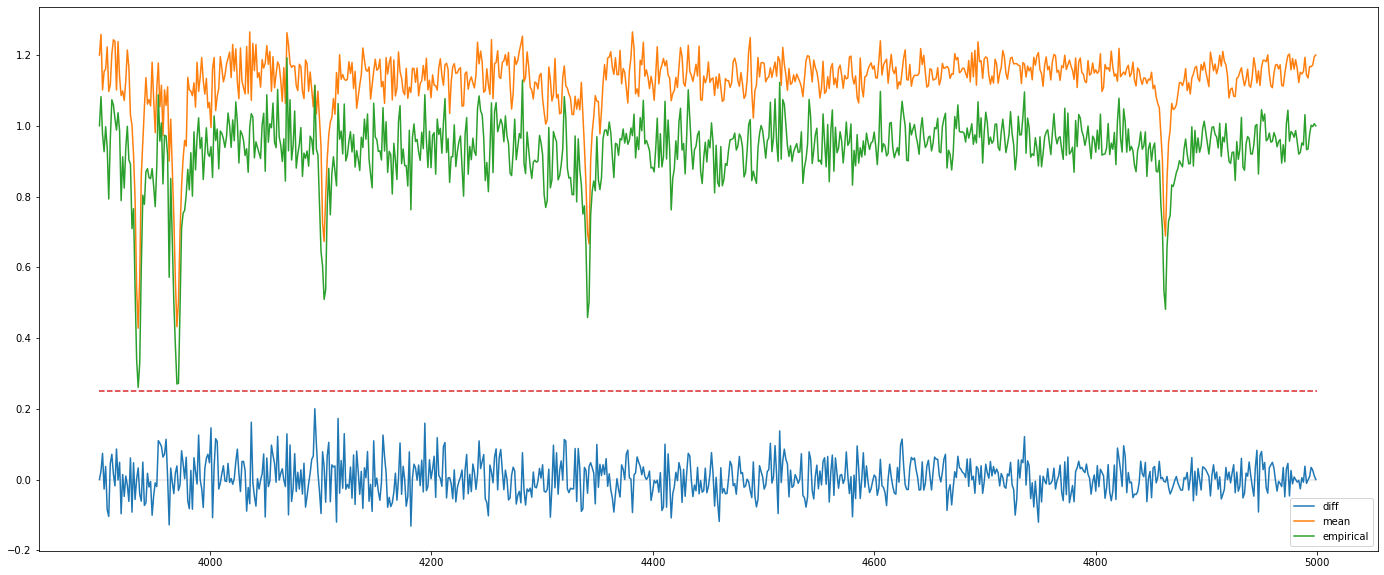

In [56]:
plt.figure(figsize=(24,10))
plt.plot(test["wavel"],test["flux_flag_1"],color="gray",alpha=0.2)
plt.plot(test["wavel"],test["diff"],label="diff")
plt.plot(df_mean["wavel"],np.add(df_mean["avg_flux"],0.2),label="mean")
plt.plot(df_single_p["wavel"],df_single_p["flux"],label="empirical")
#plt.plot(df_single_p["wavel"].where(test["flux_flag_1"] == True),
#             df_single_p["flux"].where(test["flux_flag_1"] == True),
#         label="flagged",color="k",linewidth=4)
plt.plot([3900,5000],[limit,limit],linestyle="--")
plt.legend()
plt.show()